# A try to get the pose stimation of the objects in the image

1. Get Depht stimation of the images
2. Image to point cloud  
    2.1 need camera instrinsic
3. We can run ICP to obtain the transportation matrix beetween frames
4. (otional) plot the points over time to see the movement


In [2]:
import cv2
import glob
import os
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
# load root path
root_path = os.path.abspath(os.path.join(os.path.dirname(''), ".."))
DATA_PATH = root_path + "/data/video"
DATA_PATH = root_path + "/data/rectified/originals"


## Get the images
left_images = glob.glob(DATA_PATH + "/seq_1/image_02/data/*.png")
right_images = glob.glob(DATA_PATH + "/seq_1/image_03/data/*.png")
print(DATA_PATH + "/seq_01/image_02/data/*.png")
print(len(left_images), len(right_images))

maxTimeStep = 2 # only 2 frames for testing

c:\Users\alexc\OneDrive - Danmarks Tekniske Universitet\DTU\Second Semester\34759 - Perception Autonomous\Exercises\Pfas-finalProject/data/rectified/originals/seq_01/image_02/data/*.png
145 145


In [16]:

blockSize = 27          # odd number
numDisparities = 16*10  # multiple of 16
preFilterType = 1
preFilterSize = 15
preFilterCap = 30
textureThreshold = 10
uniquenessRatio = 5
speckleRange = 7
speckleWindowSize = 600
disp12MaxDiff = 2
minDisparity = 13

disparity_imgs = []
for t in range(maxTimeStep):
    # Get the image of cameras
    print(left_images[t])
    left_image = cv2.imread(left_images[t], cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_images[t], cv2.IMREAD_GRAYSCALE)
    
    
    ####################################################
    # get the disparity map
    ####################################################
 
    stereo = cv2.StereoBM_create()

    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setPreFilterType(preFilterType)
    stereo.setPreFilterSize(preFilterSize)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setTextureThreshold(textureThreshold)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)


    disparity = stereo.compute(left_image, right_image)
    disparity_imgs.append(disparity)


c:\Users\alexc\OneDrive - Danmarks Tekniske Universitet\DTU\Second Semester\34759 - Perception Autonomous\Exercises\Pfas-finalProject/data/rectified/originals/seq_1/image_02/data\0000000000.png
c:\Users\alexc\OneDrive - Danmarks Tekniske Universitet\DTU\Second Semester\34759 - Perception Autonomous\Exercises\Pfas-finalProject/data/rectified/originals/seq_1/image_02/data\0000000001.png


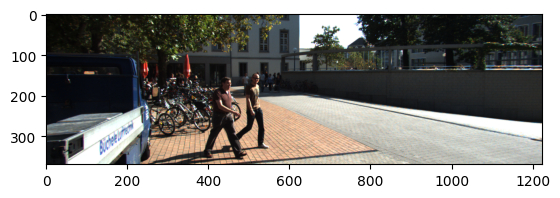

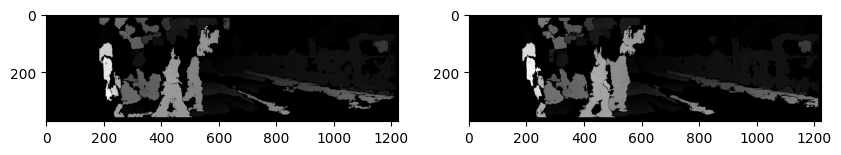

In [18]:
## plot the images in the disparity list
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(disparity_imgs[0], cmap='gray')
axs[1].imshow(disparity_imgs[1], cmap='gray')
plt.show()

## Create point clouds

In [20]:

# convert disparity map to depth
depth_img0 = o3d.geometry.Image((disparity_imgs[0]).astype(np.uint8))
depth_img1 = o3d.geometry.Image((disparity_imgs[1]).astype(np.uint8))

# convert image to open3d image
#raw_img0 = o3d.geometry.Image((left_image[0]).astype(np.uint8))
raw_img0 = o3d.io.read_image(left_images[0])
raw_img1 = o3d.io.read_image(left_images[1])


rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    raw_img0,
    depth_img0, 
    convert_rgb_to_intensity = False)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    raw_img1, 
    depth_img1, 
    convert_rgb_to_intensity = False)

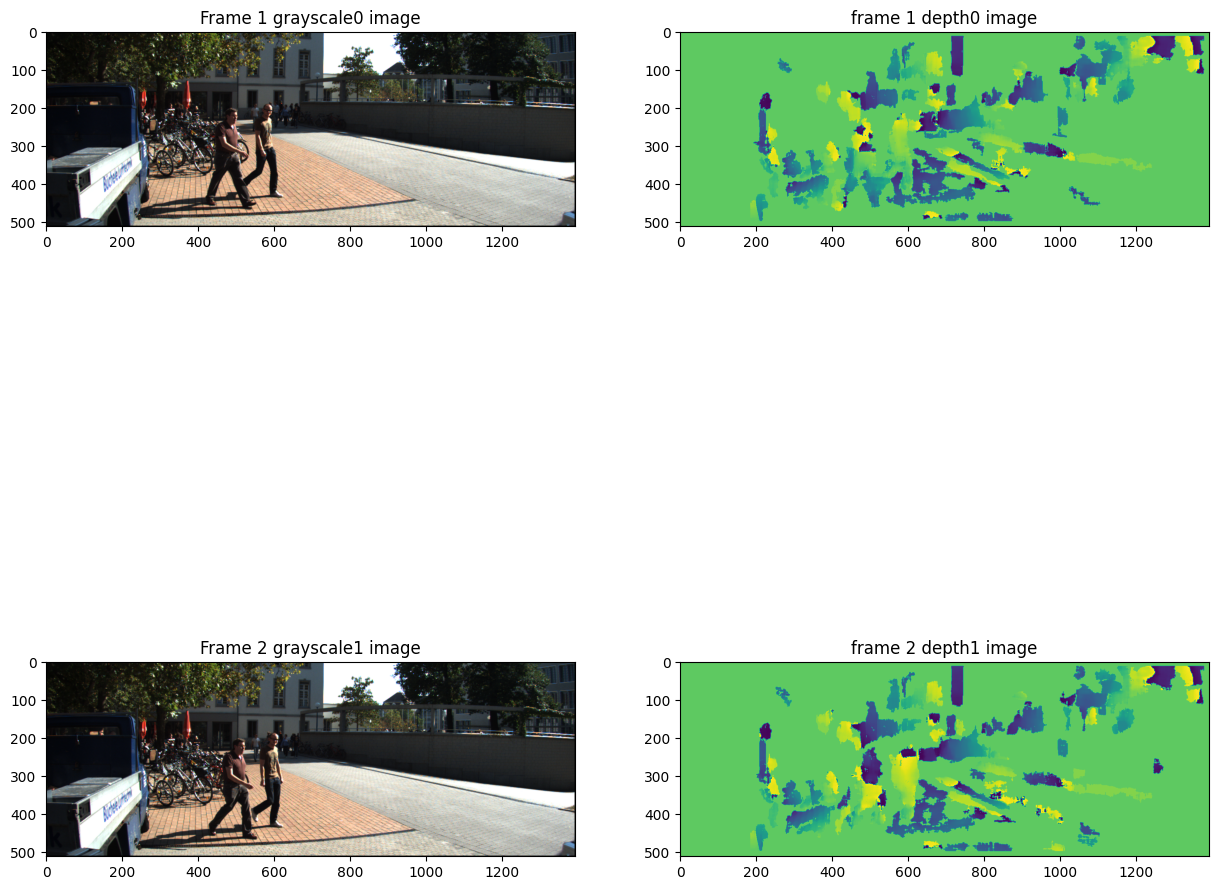

In [24]:
#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Frame 1 grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('frame 1 depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Frame 2 grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('frame 2 depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()